# COVID19-Analyis
東京都の感染者数推移を自分なりに解析をするために作ったjupyter notebookです．  
内容に責任を負いませんので，改変など自由にどうぞ．

This is jupyter notebook for visualize Tokyo Infected people trend.  
I am not responsible for the content of this article. Please feel free to modify it.


# Data Source
東京都_新型コロナウイルス陽性患者発表詳細  
https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000068/resource/c2d997db-1450-43fa-8037-ebb11ec28d4c

---
This repogitory is published under MIT license  

# COVID-19 Data Analysis based on the Tokyo 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from IPython.display import display
import requests
import os

In [27]:
"""
get file from open data source 
https://catalog.data.metro.tokyo.lg.jp/dataset/t000010d0000000068/resource/c2d997db-1450-43fa-8037-ebb11ec28d4c

"""

URL = 'https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv'
receiveData = requests.get(URL, allow_redirects=True)

if not os.path.exists('./RawData'):        
    os.mkdir('./RawData')

open('./RawData/covid-19-infectedPersonData.csv', 'wb').write(receiveData.content)


155552

In [28]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('./RawData/covid-19-infectedPersonData.csv', sep=',', parse_dates=['公表_年月日'])
df = df.fillna(0)
df = df.replace('男性','M')
df = df.replace('女性','F')
df = df.replace('代', '')
df = df.replace('不明', '-1')
df = df.replace('調査中', '-2')

for i in range(len(df.index)):
    buf = df.iloc[i,8]
    id = buf.find('代')
   
    if(id > 0):
        buf = buf[:id]
        df.iloc[i,8] = buf 
        
    id = buf.find('歳未満')
   
    if(id > 0):
        buf = '0'
        df.iloc[i,8] = buf 
        
    id = buf.find('歳以上')
    
    if(id > 0):
        buf = '100'
        df.iloc[i,8] = buf 

    
df.iloc[:,8] = df.iloc[:,8].astype('float')    
#display(df)
#display(df.dtypes)

In [41]:
def plotFitting(df, plotStart = "2020-03", plotEND = "2020-05", forcastingStart = "", forcastingEND = "",
                useOnlyWeekdaysData = False, withoutIntercept = False, isCumSum = False,
                useLogScale_X = False, useLogScale_Y = False, addFlag = False,
                ylim = [],
                plotExp = True, plotCube = True, plotSquare = True, plotLinear = True):

    if not withoutIntercept:
        def funcExp(x, a,b,c):
            return a*np.exp(b*x)+c
        def funcCube(x, a,b,c,d):
            return a*pow(x,3) + b*pow(x,2)+ c*pow(x,1) + d
        def funcSquare(x, a,b,c):
            return a*pow(x,2) + b*pow(x,1)+ c
        def funcLinear(x, a,b):
            return a*pow(x,1)+ b
    else:
        def funcExp(x, a,b):
            return a*np.exp(b*x)
        def funcCube(x, a,b,c):
            return a*pow(x,3) + b*pow(x,2)+ c*pow(x,1)
        def funcSquare(x, a,b):
            return a*pow(x,2) + b*pow(x,1)
        def funcLinear(x, a):
            return a*pow(x,1)

    def checkID(dates, buf, CheckType = "STRAT"):
        
        checkFlag = buf.count('-')
        checkFormat = ""
        error = -1
        
        if checkFlag == 1:
            checkFormat = "%Y-%m"
        elif checkFlag == 2:
            checkFormat = "%Y-%m-%d"
        else:
            display("invaild input plese use yyyy-mm-dd or yy-mm")
            error = 1
            return                       

        if CheckType == "START":
            return dates[dates >= datetime.datetime.strptime(buf,checkFormat)].index[0]
        elif CheckType == "END":
            return dates[dates <= datetime.datetime.strptime(buf, checkFormat)].index[-1]
        else:
            display("invaild CheckType plese use START or END")
            error = 2

    
    #a*pow(x,2) + b*pow(x,1)+ c

    dates = df.iloc[:,4].drop_duplicates()
    dates = dates.reset_index(drop = True)  
    
    error = -1;
    #display(len(forcastingEND))
       
    if len(forcastingStart) == 0:
        forcastingStart = plotStart
    if len(forcastingEND) == 0:
        forcastingEND = plotEND       

    initalDayID = checkID(dates, forcastingStart, CheckType = "START")
    endDayID =checkID(dates, forcastingEND, CheckType = "END")
    
    #isplay(endDayID)
    
    if error > 0:
        display("Error ocurred!")
        return
    
    #display(dates)

    array = np.array([])

    sampleDates = dates[initalDayID:endDayID+1]   
    #display(sampleDates)
    
    if useOnlyWeekdaysData:
        sampleDates = sampleDates[sampleDates.apply(lambda x: x.weekday() < 5)]
    
    for date in sampleDates:
        df_tmp = df[df['公表_年月日'] == date]
        td = date-dates[initalDayID]   

        if len(array) == 0:
            array = np.array([[date, td.days, len(df_tmp.index)]])
        else:
            array = np.append(array, np.array([[date, td.days, len(df_tmp.index)]]), axis= 0)        
    
    #display(array)

    x = array[:,0]
    y = array[:,2].astype('float')
    
    if isCumSum:
        y = y.cumsum()
    
    xdata = array[:,1].astype('float')

    # fitting exponential
    poptExp, pcovExp = curve_fit(funcExp, xdata, y)
    ydataExp = funcExp(xdata, *poptExp)
    R2EXP = r2_score(y, ydataExp)
    
    # fitting Cube fuction
    poptCube, pcovCube = curve_fit(funcCube, xdata, y)
    ydataCube = funcCube(xdata, *poptCube)
    R2Cube = r2_score(y, ydataCube)

    # fitting Square fuction
    poptSquare, pcovSquare = curve_fit(funcSquare, xdata, y)
    ydataSquare = funcSquare(xdata, *poptSquare)
    R2Square = r2_score(y, ydataSquare)

    # fitting Linear fuction
    poptLinear, pcovLinear = curve_fit(funcLinear, xdata, y)
    ydataLinear = funcLinear(xdata, *poptLinear)
    R2Linear = r2_score(y, ydataLinear)

    plt.Figure(figsize=(1,5))
    plt.style.use('bmh')
    plt.xticks(rotation=45)
    plt.xlabel('date')
    
    if isCumSum:
        plt.ylabel('Cumulative infected people number')
    else:
        plt.ylabel('Daily infected people number')

    if useLogScale_X:
        plt.xscale("log")    
        
    if useLogScale_Y:
        plt.yscale("log")
        
    if len(ylim) == 2:
        plt.ylim(ylim)
    
    #plt.ylim([0,200])
    
    x_weekdays = [ x[dayFlag[0]] for dayFlag 
                      in enumerate(sampleDates.apply(lambda x: x.weekday() < 5)) if dayFlag[1]]    
    y_weekdays = [ y[dayFlag[0]] for dayFlag 
                      in enumerate(sampleDates.apply(lambda x: x.weekday() < 5)) if dayFlag[1]]
    
  
    x_holidays = [ x[dayFlag[0]] for dayFlag 
                      in enumerate(sampleDates.apply(lambda x: x.weekday() < 5)) if not dayFlag[1]]  
    y_holidays = [ y[dayFlag[0]] for dayFlag 
                      in enumerate(sampleDates.apply(lambda x: x.weekday() < 5)) if not dayFlag[1]]  
    
    if not addFlag:
        plt.bar(x_weekdays, y_weekdays, label = "WeekDay", color = "b")
        plt.bar(x_holidays, y_holidays, label = "HoliDay", color = "r")  
    
    if not isCumSum:
        plt.title("Daily Infected People Forcast Number")
    else:
        plt.title("Cumulative Infected People Number Forcast")        
        
    x = np.arange(plotStart, plotEND, dtype='datetime64[D]')
    xdata=np.array(range(len(x))).astype("float")
    
    alpha = 1
    if addFlag:
        alpha = 0.5

    if not withoutIntercept:
        if plotExp:
            plt.plot(x, funcExp(xdata, *poptExp), ls = '--', c = 'red' , alpha = alpha,
                label='fit: A * e^Bx +C\nA=%3.2f, B=%3.2f, C=%3.2f\nR^2 = %2.3f' % (poptExp[0],poptExp[1],poptExp[2], R2EXP))
        
        if plotCube:
            plt.plot(x, funcCube(xdata, *poptCube), ls = '--', c = 'green', alpha = alpha,
                label='fit: A * x^3 + B * x^2 + C * x + D \nA=%3.2f, B=%3.2f, C=%3.2f, D=%3.2f\nR^2 = %2.3f' % (poptCube[0],poptCube[1],poptCube[2],poptCube[3], R2Cube))
        
        if plotSquare:
            plt.plot(x, funcSquare(xdata, *poptSquare), ls = '--', c = 'darkcyan', alpha = alpha,
                label='fit: A * x^2 + B * x + C\nA=%3.2f, B=%3.2f, C=%3.2f\nR^2 = %2.3f' % (poptSquare[0],poptSquare[1],poptSquare[2], R2Square))
        
        if plotLinear:
            plt.plot(x, funcLinear(xdata, *poptLinear), ls = '--', c = 'magenta', alpha = alpha,
                label='fit: A * e^Bx +C\nA=%3.2f, B=%3.2f\nR^2 = %2.3f' % (poptLinear[0], poptLinear[1], R2Linear))
    else:
        if plotExp:
            plt.plot(x, funcExp(xdata, *poptExp), ls = '--', c = 'red' ,alpha = alpha,
                label='fit: A * e^Bx +C\nA=%3.2f, B=%3.2f, C=%3.2f\nR^2 = %2.3f' % (poptExp[0],poptExp[1],0, R2EXP))
        
        if plotCube:
            plt.plot(x, funcCube(xdata, *poptCube), ls = '--', c = 'green' ,alpha = alpha,
                label='fit: A * x^3 + B * x^2 + C * x + D \nA=%3.2f, B=%3.2f, C=%3.2f, D=%3.2f\nR^2 = %2.3f' % (poptCube[0],poptCube[1],poptCube[2],0, R2Cube))
        if plotSquare:
            plt.plot(x, funcSquare(xdata, *poptSquare), ls = '--', c = 'darkcyan' ,alpha = alpha,
                label='fit: A * x^2 + B * x + C\nA=%3.2f, B=%3.2f, C=%3.2f\nR^2 = %2.3f' % (poptSquare[0],poptSquare[1],0, R2Square))
        
        if plotLinear:
            plt.plot(x, funcLinear(xdata, *poptLinear), ls = '--', c = 'magenta' ,alpha = alpha,
                label='fit: A * e^Bx +C\nA=%3.2f, B=%3.2f\nR^2 = %2.3f' % (poptLinear[0],0, R2Linear))
    
    plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
    if not addFlag:
        plt.show()

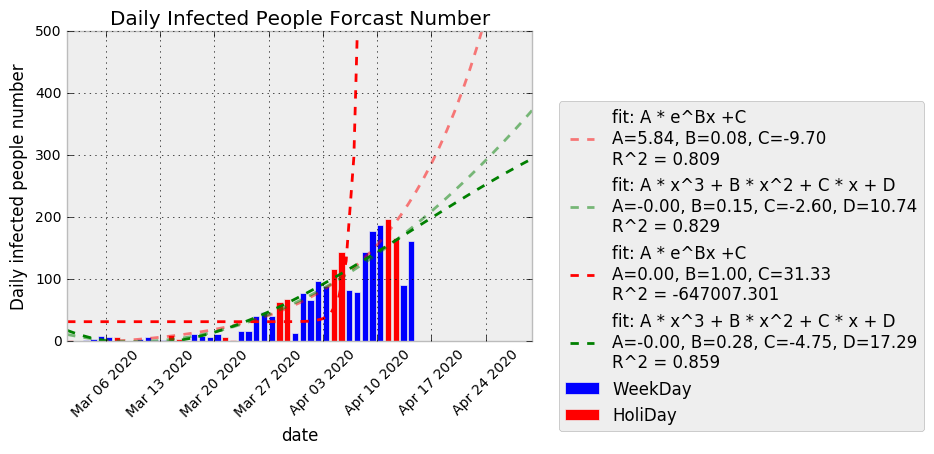

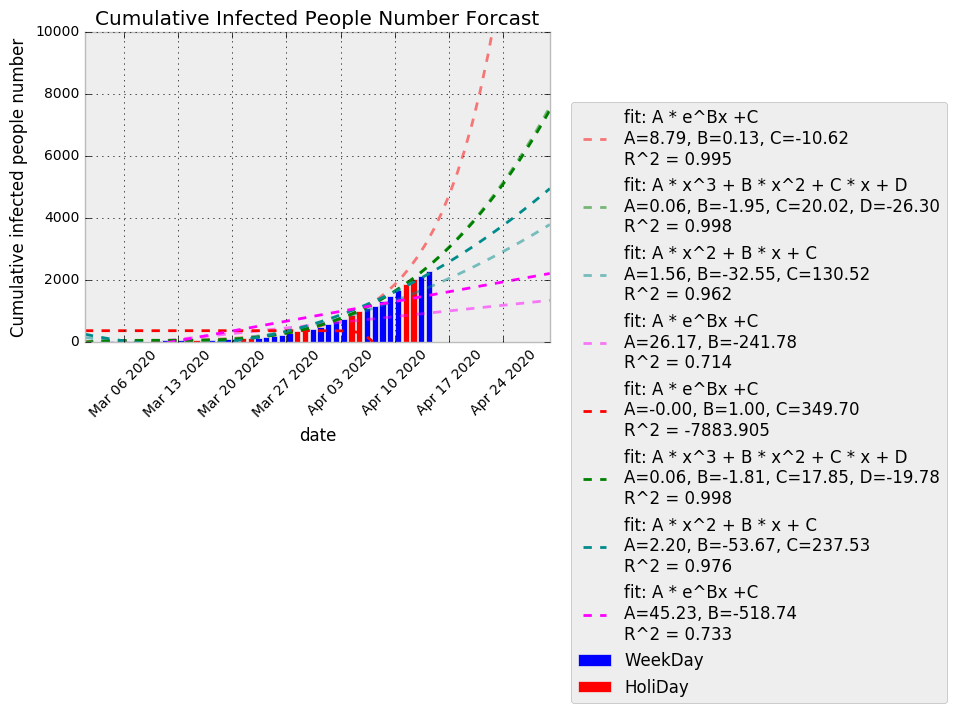

In [42]:
plotFitting(df, plotStart="2020-03", plotEND= "2020-05", forcastingEND="2020-04-07", addFlag= True, ylim=[0,500], plotSquare =False, plotLinear= False)
plotFitting(df, plotStart="2020-03", plotEND= "2020-05", plotSquare =False, plotLinear= False)


plotFitting(df, plotStart="2020-03", plotEND= "2020-05", forcastingEND="2020-04-07", addFlag= True, isCumSum = True)
plotFitting(df, plotStart="2020-03", plotEND= "2020-05", isCumSum = True, ylim = [0, 10000])

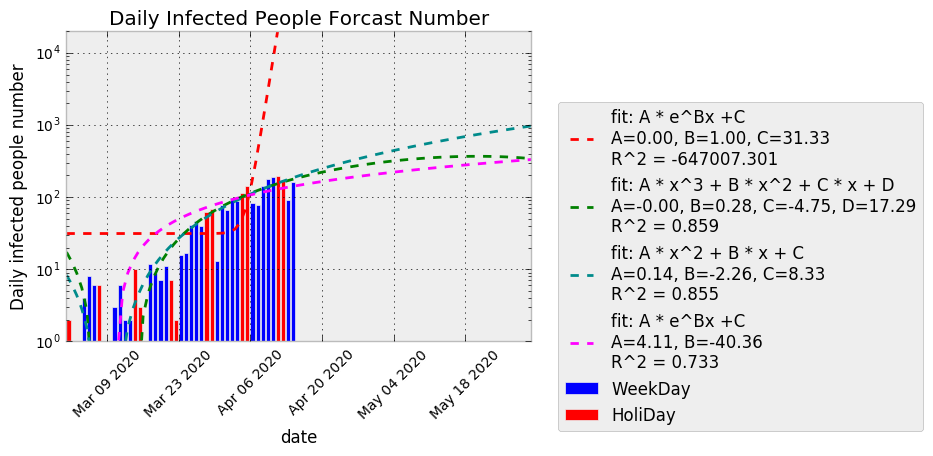

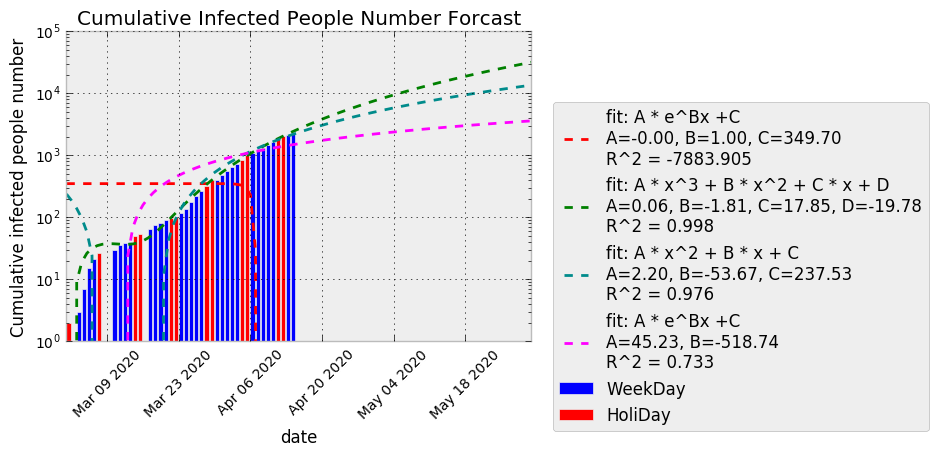

In [43]:
plotFitting(df, plotStart="2020-03", plotEND= "2020-06", useLogScale_Y=True, ylim = [1,20000])
plotFitting(df, plotStart="2020-03", plotEND= "2020-06", isCumSum = True, useLogScale_Y=True)

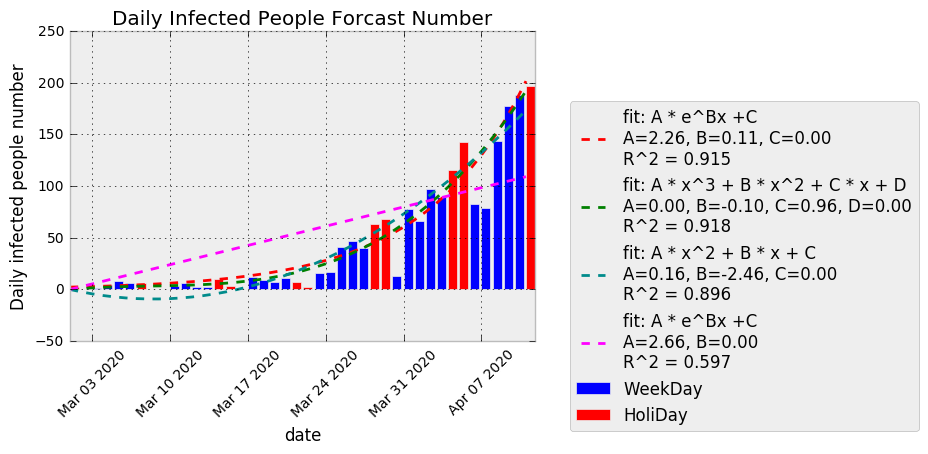

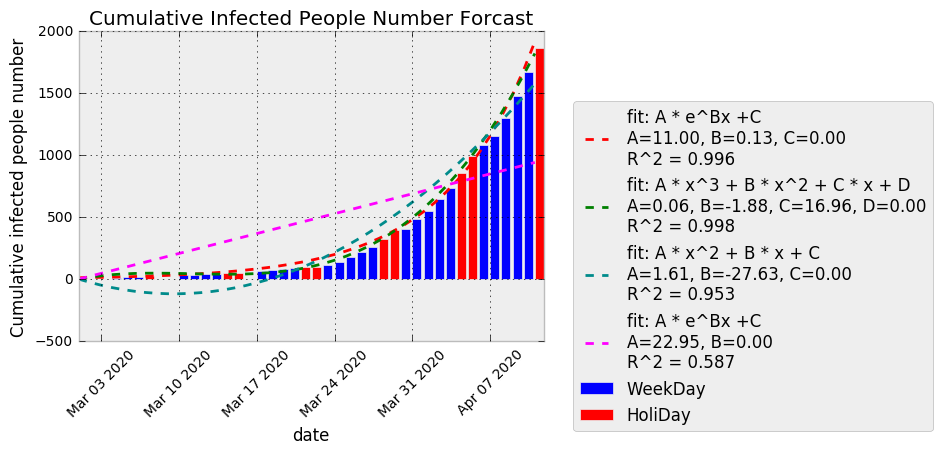

In [33]:
plotFitting(df, plotStart="2020-03", plotEND= "2020-04-12", withoutIntercept= True)
plotFitting(df, plotStart="2020-03", plotEND= "2020-04-12", withoutIntercept= True, isCumSum = True)

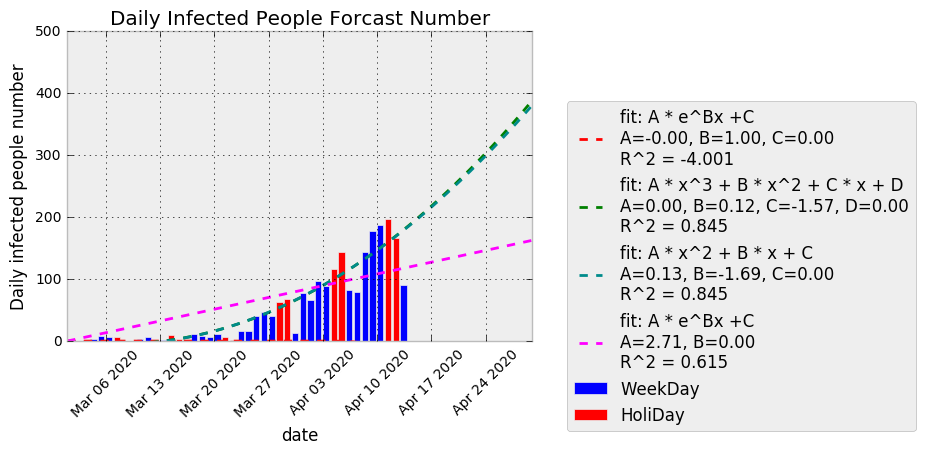

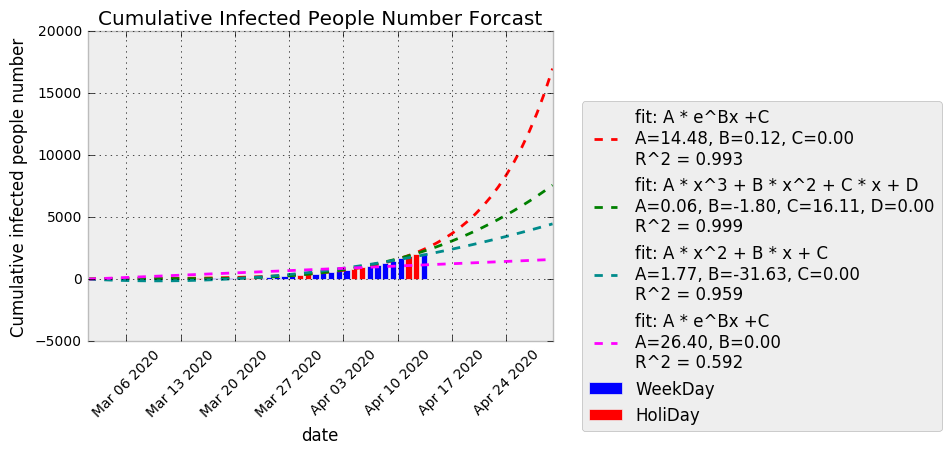

In [37]:
plotFitting(df, plotStart="2020-03", plotEND= "2020-05", withoutIntercept= True, ylim=[0,500])
plotFitting(df, plotStart="2020-03", plotEND= "2020-05", withoutIntercept= True, isCumSum = True)